<h1 align=center style="color: #005496; font-size: 4.2em;">TensorFlow</h1>
<h2 align=center>Laboratory on Neural Networks</h2>

***

<img src="https://camo.githubusercontent.com/ee91ac3c9f5ad840ebf70b54284498fe0e6ddb92/68747470733a2f2f7777772e74656e736f72666c6f772e6f72672f696d616765732f74665f6c6f676f5f7472616e73702e706e67">

***

## Introduction

Few years back, Google has open-sourced their machine learning framework: **TensorFlow**. Since then, it has become one of the most used tools in machine learning, both for research purposes and for production systems. TensorFlow is very flexible and can handle a wide range of neural architectures. With TensorFlow you can potentially deploy a *computational graph* over a cluster of machines and let them learn a very big neural model seamlessly in parallel.

In this lecture we will see how we can build a simple Neural Network capable of categorizing images from the *MNIST* dataset into digits. We will closely follow the (MNIST For ML Beginners)[https://www.tensorflow.org/versions/master/get_started/mnist/beginners] tutorial, so if you want to dig deeper you can go check that out.

This lecture assumes familiarity with the Python programming language and the libraries we have seen in the previous lecture Numpy, Matplotlib and Scikit-learn.


## Requirements

1. Python (preferably version > 3.4): https://www.python.org/downloads/
2. TensorFlow: https://www.tensorflow.org/versions/master/install/ (if you have a dedicated GPU, you may want to install TensorFlow with GPU support)

## References

- https://www.tensorflow.org
- https://www.tensorflow.org/versions/master/get_started/mnist/beginners
- https://www.tensorflow.org/versions/master/get_started/mnist/pros
- https://www.tensorflow.org/versions/master/programmers_guide/
- http://yann.lecun.com/exdb/mnist/


# TensorFlow

Let's dive into how to declare and train a Neural Network with *TensorFlow*. In order to ease the parallelization of the training process over several GPUs and or machines, TensorFlow works in two stages. First, there is a *declarative* stage, in which all the operations needed for training our machine learning model are declared. These interconnected operations form a so-called **computational graph**. The second stage consists in deploying the computaional graph over the target machine(s) and running it within a TensorFlow **session**. 

Let's start with the first stage. Remember, all the operations we perform in the first stage are only **declared**, they will only be run once we execute them within a TensorFlow session.

## MNIST dataset

*MNIST* is a dataset containing labelled images of handwritten digits. This dataset is similar to the *digits* dataset we have seen in the previous lecture, but the images here are larger, 28 by 28 pixels.

We can use TensorFlow directly to download and read the MNIST data:

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

mnist

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f5e6468f208>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f5e9b09f898>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f5e5fed8e48>)

The data instances in MNIST are images represented by Numpy arrays contaning 784 numbers between 0 and 1, i.e. the gray scale relative intensity of the pixels (0 means white, 1 means black).

<img src="https://www.tensorflow.org/images/MNIST-Matrix.png" width="600px" />

***

MNIST already comes with a train-validation-test split. The training data `mnist.train.images` is a *tensor* of shape (55000, 784).

<img src="https://www.tensorflow.org/images/mnist-train-xs.png" width="600px" />

***

The labels are encoded into a "one-hot" representation. Each label `y` is a vector of 10 0-1 elements, in which only the position associated with the true digit is set to 1, the others are set to 0. The training labels `mnist.train.labels` is also a tensor of shape (55000, 10).

<img src="https://www.tensorflow.org/images/mnist-train-ys.png" width="600px" />

Let's visualize one of these images as we did in the previous lecture.

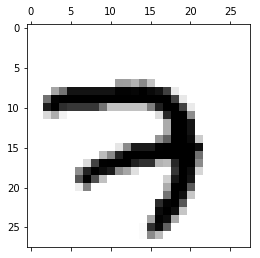

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

x = mnist.train.images[0].reshape(28, 28)

plt.gray()
plt.matshow(1.0 - x) # 1.0 - x simply inverts the fading direction of the image
plt.show()


As said, the label is instead an array of size 10.

In [3]:
y = mnist.train.labels[0]

y

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

## Softmax Regression

The first thing we are going to implement using TensorFlow is a simple softmax regression model to predict the digits from the images. Softmax regression is a generalization of Logistic Regression to multi-class classification.

In softmax regression we define a linear model for each possible class. These models provide evidence supporting the image `x` being of the particular class `i`:

\begin{equation}
    \theta_i = \sum_{1 \le j \le 784} W_{i,j} \cdot x_j + b_i
\end{equation}

A softmax function is then applied to each linear model in order to get the probability $y_i$ of the image being of class `i`:

\begin{equation}
    y_i = \text{softmax}(\theta_i) = \frac{e^{\theta_i}}{\sum_{j} e^{\theta_j}}
\end{equation}

This is a schematic view of the operations we are a doing:

<img src="https://www.tensorflow.org/images/softmax-regression-scalargraph.png" width="400px" />

***

Spelling out the equations of our model:

<img src="https://www.tensorflow.org/images/softmax-regression-scalarequation.png" width="400px" />

***

The vectorized form:

<img src="https://www.tensorflow.org/images/softmax-regression-vectorequation.png" width="400px" />

***

The vectorized equation is therefore the following:

\begin{equation}
    y = \text{softmax}(W \cdot x + b)
\end{equation}

Where $y$ is a $1 \times 10$ column vector, $W$ is a $10 \times 784$ matrix, $x$ is a $1 \times 784$ column vector and $b$ is a $1 \times 10$ column vector. While we used column vectors for ease of exposition, in the implementation is much more convenient to use row vectors for $x$, $b$ and $y$. Hence, the matrix `W` in the code below will be of shape (784, 10). Let's now delve into the definition of this softmax model with TensorFlow.

As said before, at this stage we need to define a model only in terms of the graph of computations. We do not need to use the actual data now, therefore we define a `placeholder` for the input vector `x`. 

In [4]:
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 784])

We just declared a placeholder for a tensor containing values of type `float32`. The second parameter is the shape of this tensor. Here the first dimension is the number of examples that we are going to pass to the model and `None` means that we don't know apriori how many examples we'll be passing. The second dimension is the shape of the images.
This placeholder is a value that we can use to declare the operations we want to perform in the computational graph and it will be populated with actual data as soon as we deploy the graph and we run it.

Now we need to specify the weights and the biases. These parameters are not data we give to the model but rather variables we want TensorFlow to estimate. We declare them as `Variable` and we initialize them with zeros.

In [5]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

Now, the final model is the following:

In [6]:
y_hat = tf.nn.softmax(tf.matmul(x, W) + b)

The variable `y_hat` is going to hold the prediction of our model.

## Training

After we define the model, we want to train it using that data we have. To do so, we first need to define a **loss function**. For this task we are going to use the *cross-entropy* loss:

\begin{equation}
    H_{y}(\hat{y}) = - \sum_i y_i \log(\hat{y}_i)
\end{equation}

Where $\hat{y}$ is the distribution predicted by our model and $y$ is the true probability distribution of the classes (i.e. the one-hot vector).

Now, in order to use cross-entropy for training, we need to define a place-holder for our true labels.

In [7]:
y = tf.placeholder(tf.float32, [None, 10])

And now we can define the expression that will compute the cross-entropy. Our loss is going to be the average cross-entropy over all training examples.

In [8]:
# First y * tf.log(y_hat) computes the element-wise multiplication of the two resulting vectors
# Second, tf.reduce_sum( , reduction_indices=[1]) computes the sum along the second dimension (the first one are the examples)
# Finally, tf.reduce_mean() computes the mean over the first dimension, i.e. the examples
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))

Now we can pick a training algorithm and let it minimize our loss function; we are going to use gradient descent with a $0.5$ step-size.

In [9]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

We are now finally ready to start the training into an `InteractiveSession`. But first let's initialize our variables:

In [10]:
# Declares the session
sess = tf.InteractiveSession()

# Run the global variables initializer to initialize the variables we declared earlier
tf.global_variables_initializer().run()

Now we can train the model. We'll run `1000` epochs using a batch of `100` examples at each time.

In [11]:
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})

Done!

Notice that we used `feed_dict` to replace each placeholder with actual data. We now want to evaluate our model. Before we do that, one cool thing we can do with neural networks on computer vision tasks is to visualize "what" the model learned:

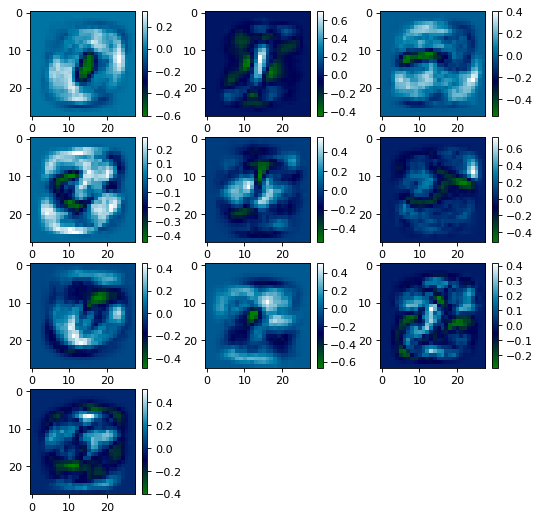

In [12]:
w = W.eval()
fig = plt.figure(figsize=(8, 8), dpi=80)
for digit in range(w.shape[1]):
    ax = fig.add_subplot(4,3,digit+1)
    ax.set_aspect('equal')
    plt.imshow(w.T[digit].reshape(28,28), interpolation='nearest', cmap=plt.cm.ocean)
    plt.colorbar()
plt.show()

## Evaluation

Let's now evaluate our model on the test set. For the evaluation we are going to proceed in the same way as we did for the training phase: first we declare the operations we want to do, then we run them within a session. Now, remember that `y_hat` contains the probability of each class; to make an actual prediction we are going to take the `argmax` of that vector, so we get the class with highest probability.

To get the accuracy of the model, we first need to compare the prediction of the model with the true labels.

In [ ]:
# argmax( , 1) means return only the first argmax
correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y, 1))

The variable `correct_prediction` will contain a array of Booleans where `True` means the prediction is equal to the label, and thus it is correct, or `False` otherwise. 

Notice that we used the same variables `y_hat` and `y` we used for the training. That is fine because those variables are just placeholders, they only get assigned within a session so we can reuse them for different operations with different meanings. For the evaluation part `x` is going to get the test images, so that `y_hat` will contain the predictions over the test set, while `y` is going to get the test labels in order to calculate the accuracy over the test set.

Let's compute the accuracy and print it.

In [ ]:
# Declare the computation of the mean accuracy over the test set
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Actually run the accuracy computation feeding the test data
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Good! Our model works (sort of). These performance on MNIST are way too low. The state-of-the-art on this dataset has an accuracy of $0.9979$. Let's try to achieve a better accuracy by refining a bit our model.

## Deep architectures

<p>
We are now going to define a deep neural network capable of classifying digits much better than the shallow softmax we used before. We are going to use two convolutional layers alternated with 2 max pool layers, followed by a ReLU layer regularized with dropout, and finally we'll get predictions using again a softmax layer. This is what it a schematic view of the architecture (bottom up). 
</p>

<img src="https://www.tensorflow.org/images/mnist_deep.png" style="width: 350px" />

***

### Convolutional layer

Convolutional Neural Networks are based on a method for extracting meaningfull features from images, exploiting locality and parameter sharing between "close" pixels. In particular, a convolutional layer takes as input a matrix and divides it into smaller "patches". It outputs a number of features for each patch. The resulting tensor will be similar to the one in the following picture.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png" width="400px" />

***

### Max pool layer

The max pool layer is a filter that is used to reduce the number of the input dimensions between two convolutional layers. It is useful for dimensionality reduction, avoids overfitting, etc. The following is a simple example:

<img src="http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-05-at-2.18.38-PM.png" width="400px" />

***

### ReLU layer

Rectified Linear Unit (ReLU) is a particular activation function of the type: $max(0, \theta)$. ReLUs have become very wide spread thanks because, differently from sigmoids, they do not saturate gradients when used with backpropagation. This has allowed neural networks to become deeper and increased their representational power. The following image compares several activation functions and their gradients.

<img src="https://d9johdpvmzlgp.cloudfront.net/images/Blog/af.jpg" width="700px" />

***

### Dropout

Dropout is a regularization technique for neural networks. When using dropout, we set a probability for dropping random nodes from the networks at each gradient descent step. In this way, the network is going to learn a more robust model, not relying too much on a single node for a prediction. In some sense, using dropout we are "sampling" a lot of different networks and learning them, and finally we are left with the "average" network, which is less susceptible to outliers. Dropouts also helps in avoiding overfitting.

<img src="https://pgaleone.eu/images/dropout/dropout.jpeg" width="400px" />

***

Now let's define out deep neural network, train it and then evaluate it, in the same way we did before for the softmax model.

This time we are going to initialize our weight and bias variables in a different way. For convenience, we are going to use the following initialization functions.

In [ ]:
# Initializes a weight variable by sampling from a truncated normal distribution with standard deviation of 0.1
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

# Initializes a bias variable with a constant value 0.1
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Another couple of convenience methods we are going to define are useful for initializing the convolutional and max pool layers. For the convolutional layers we are going to pass the input `x`, which is a 4D tensor of type [batch_size, width, height, channels]. Our images are in gray-scale, so there is only one channel; if we had RGB values the fourth dimension would instead contain three channels. The filter `W` instead contains the parameters that the network needs to learn, whose shape is [filter_height, filter_width, in_channels, out_channels], where filter_height and filter_width are the dimensions of the patches; the in_channels are the input channels, equal to the channels of the input `x`; the output channels are the number of features we want to extract. The strides are the "steps" in each direction between each patch, whereas with the padding parameter we tell the convolutional layer how to deal with the patches at the edges of the image, the `SAME` padding adds dummy values to the edges in order to keep the ouptup dimensions the same as the inputs. Visually:

<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/assets/same_padding_no_strides.gif" width="400px" />

***

For the max pool layer instead we are going to use a $2 \times 2$ pooling, which halves the dimension of our input `x`. We set the `ksize` to $2 \times 2$ in the dimensions of the height and width of the image. The strides are also going to be $2 \times 2$ in those dimensions in order to avoid overlappings. The `SAME` padding is going to preserve the input dimension as before.

In [ ]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', use_cudnn_on_gpu=False)

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

For the first convolutional layer we are going to extract $32$ features out of $5 \times 5$ patches. So we need a filter $W_1$ of shape [5, 5, 1, 32], and a bias $b_1$ of size $32$. 

In [ ]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

Now, rememeber that our images `x` are long vectors containing 784 values. We want to reshape these inputs into a $28 \times 28$ matrices. Remember that here we are only defining the graph of computation, so `x` is a placeholder, and this operation is only being defined here.

In [ ]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

We are now going to convolve the `x_image` input with the weight tensor `W`, add the bias and then pass the result into a ReLU activation function. We then apply the max pool layer on top of that.

In [ ]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

We now put a second convolutional layer on top of the previous one. The previous layer has an output shape of [batch_size, 14, 14, 32], since the convolution extracted 32 features out of each patch, and the max pool halved the width and height of the images. In the second layer we are going to extract 64 features for patch.

In [ ]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

The following layer will be a densely connected ReLU layer. In order to connect each component, we first need to flatten our input, which is the output of the previous layer. The previous layer has shape [batch_size, 7, 7, 64], has we convolved the patches into 64 features and the second max pool further reduced the width and height of the images to 7. The input of the densely connected layer will therefore have $7 \cdot 7 \cdot 64$ nodes. We will output $1024$ features from this layer.

In [ ]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

Let's now apply Dropout. As we said, we need to define the "keep" probability, i.e. the probability each node is retained when applying the dropout. We need a placeholder for that.

In [ ]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

We now define the output layer of the network, which is going to be a fully connected softmax layer with 10 outputs.

In [ ]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
y_hat = tf.nn.softmax(y_conv)

We can again define the cross entropy loss function.

In [ ]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))

This time we are going to use an Adam SGD algorithm with $10^{-4}$ learning rate.

In [ ]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

As before we compute the accuracy for evaluation.

In [ ]:
correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

We are going to train the network for $1000$ epochs, each using a $50$ examples mini-batch. The dropout keep probability is going to be $0.5$. Each $100$ epochs we are also going to evaluate our current model. Notice that in evaluation the `keep_prob` is equal to `1.0` as we want to use the full network for the prediction.

In [ ]:
sess.run(tf.global_variables_initializer())
for i in range(1000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0})
        print('step {}, training accuracy {}'.format(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y: batch[1], keep_prob: 0.5})

# Dividing evaluation in batches for memory constraints
import numpy as np
accuracy_values = []
for j in range(100):
    batch = mnist.test.next_batch(100)
    accuracy_values.append(sess.run(accuracy, feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0}))

print('test accuracy {}'.format(np.mean(accuracy_values)))